In [2]:
import cv2 # must manually add to anaconda
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter # must manually add to anaconda
from PIL import Image
import pylab as py
import statistics

%matplotlib inline

In [4]:
# opens video and captures relevant info
file = "tumorCenterMOV.mov" #NOTE: IF YOU ARE USING A MAC, YOU WILL NEED TO EDIT THIS TO OPEN CORRECT DIRECTORY
capture = cv2.VideoCapture(file)

print ("\t Width: ", capture.get(cv2.CAP_PROP_FRAME_WIDTH))
print ("\t Height: ",capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
print ("\t FourCC: ",capture.get(cv2.CAP_PROP_FOURCC))
print ("\t Framerate: ",capture.get(cv2.CAP_PROP_FPS))
numframes = capture.get(7)
print ("\t Number of Frames: ",numframes)

	 Width:  90.0
	 Height:  156.0
	 FourCC:  828601953.0
	 Framerate:  6.666666666666667
	 Number of Frames:  80.0


In [5]:
# finds the 9 center pixels and takes the median to find the center pixel
def findPixel (img, r): # could potentially expand to look for g/b values too -- beyond our scope
      
    desiredPixelX = []
    desiredPixelY = []
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            pixel = img.getpixel((x, y))
            if (pixel[0] == r): # and pixel[2] == g and pixel[3] == b):
                desiredPixelX.append(x)
                desiredPixelY.append(y)
                
    if (len(desiredPixelX) != 0):
        center_x = statistics.median(desiredPixelX)
        center_y = statistics.median(desiredPixelY)
        return (center_x, center_y)
    else:
        return (-1,1)

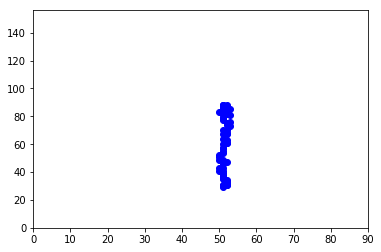

In [6]:
# measures the path of the center pixel over time
measuredTrack = np.zeros((int(numframes),2)) - 1

count = 0 

for i in range(int(numframes)):
    count += 1
    #img2 = capture.read()[1]
    img = Image.open("Frames/Center/frame%d_center.png" % i) 
    pixel = findPixel(img,254) # update this per pixel value
    measuredTrack[count-1,:] = pixel
    plt.plot(pixel[0],pixel[1],'ob')
    
    
    
#print (measuredTrack)
np.save("tumorTrajectory", measuredTrack)
plt.axis([0,90,0,156])
plt.show()

In [7]:
Measured = np.load("tumorTrajectory.npy") 
while True:
   if Measured[0,0]==-1.:
       Measured=np.delete(Measured,0,0) # deletes first frames if they do not have a center pixel -- this was more important for ball tracking tutorial; not as applicable here
   else:
       break
numMeas = Measured.shape[0]

In [8]:
MarkedMeasure = np.ma.masked_less(Measured,0)

print (MarkedMeasure)

[[51.0 60.0]
 [52.0 67.0]
 [53.0 73.0]
 [51.0 77.0]
 [51.0 81.0]
 [50.0 83.0]
 [52.0 84.0]
 [51.0 86.0]
 [52.0 87.0]
 [51.0 87.0]
 [52.0 86.0]
 [52.0 87.0]
 [-- 1.0]
 [-- 1.0]
 [51.0 88.0]
 [52.0 87.0]
 [-- 1.0]
 [51.0 86.0]
 [-- 1.0]
 [53.0 81.0]
 [53.0 76.0]
 [52.0 70.0]
 [51.0 57.0]
 [51.0 64.0]
 [50.0 51.0]
 [52.0 47.0]
 [51.0 37.0]
 [50.0 41.0]
 [52.0 33.0]
 [51.0 31.0]
 [51.0 29.0]
 [51.0 31.0]
 [52.0 32.0]
 [51.0 36.0]
 [51.0 41.0]
 [51.0 46.0]
 [50.0 52.0]
 [51.0 57.0]
 [52.0 63.0]
 [51.0 70.0]
 [52.0 75.0]
 [51.0 79.0]
 [52.0 82.0]
 [51.0 84.0]
 [52.0 85.0]
 [51.0 86.0]
 [-- 1.0]
 [-- 1.0]
 [-- 1.0]
 [52.0 88.0]
 [51.0 88.0]
 [51.0 88.0]
 [52.0 87.0]
 [52.0 86.0]
 [-- 1.0]
 [53.0 85.0]
 [-- 1.0]
 [51.0 79.0]
 [52.0 74.0]
 [52.0 68.0]
 [52.0 61.0]
 [51.0 55.0]
 [51.0 49.0]
 [51.0 43.0]
 [51.0 39.0]
 [51.0 35.0]
 [52.0 32.0]
 [52.0 31.0]
 [52.0 31.0]
 [51.0 30.0]
 [52.0 34.0]
 [51.0 38.0]
 [50.0 43.0]
 [50.0 49.0]
 [51.0 54.0]
 [52.0 61.0]
 [51.0 67.0]
 [-- 1.0]
 [-- 1.0]
 [-- 1

In [9]:
# Check this!
Transition_Matrix=[[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]] #x,y,vx,vy -- basically says x/vx are related and y/vy are related
Observation_Matrix=[[1,0,0,0],[0,1,0,0]] # however, you are only making direct observations on x & y

In [10]:
# Process noise = system changes
# Measuring noise = observations

xinit = MarkedMeasure[0,0]
yinit = MarkedMeasure[0,1]
vxinit = MarkedMeasure[1,0] - MarkedMeasure[0,0] # can init to 0 -- btter with this
vyinit = MarkedMeasure[1,1] - MarkedMeasure[0,1]
initstate = [xinit,yinit,vxinit,vyinit]
initcovariance = 1.0e-2 * np.eye(4) # tweak this if first few frames are off -- look at state covaraiance over time
transistionCov = 1.0e-3 * np.eye(4) # process noise
observationCov = 1.0e-1 * np.eye(2) # measurement noise -- higher is less trust
kf = KalmanFilter(transition_matrices = Transition_Matrix,
            observation_matrices = Observation_Matrix,
            initial_state_mean = initstate,
            initial_state_covariance = initcovariance,
            transition_covariance = transistionCov,
            observation_covariance = observationCov)

In [11]:
# These are the two different methods of applying Kalman filters -- read docs
# kf.em().smooth() is significantly better for our uses here -- tutorial uses kf.filter
(filtered_state_means, filtered_state_covariances) = kf.filter(MarkedMeasure)
(smoothed_state_means, smoothed_state_covariances) = kf.em(MarkedMeasure).smooth(MarkedMeasure)

C:\Users\Zach Barrett\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
C:\Users\Zach Barrett\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\Zach Barrett\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


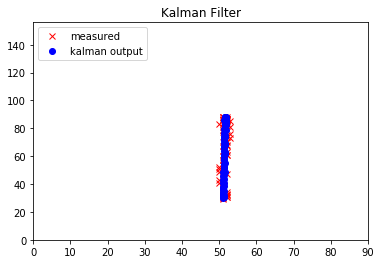

In [12]:
#(filtered_state_means, filtered_state_covariances) = kf.filter(MarkedMeasure)
(smoothed_state_means, smoothed_state_covariances) = kf.em(MarkedMeasure).smooth(MarkedMeasure)
# comment out one of these above ^^^

plt.plot(MarkedMeasure[:,0],MarkedMeasure[:,1],'xr',label='measured')
plt.axis([0,90,0,156])
plt.hold(True)

#plt.plot(filtered_state_means[:,0],filtered_state_means[:,1],'ob',label='kalman output')
plt.plot(smoothed_state_means[:,0],smoothed_state_means[:,1],'ob',label='kalman output')
# comment out the corresponding filtering method to the above comment out in this cell

plt.legend(loc=2)
plt.title("Kalman Filter")

plt.savefig("Kalman Filter.png")

plt.show()

C:\Users\Zach Barrett\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
C:\Users\Zach Barrett\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\Zach Barrett\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


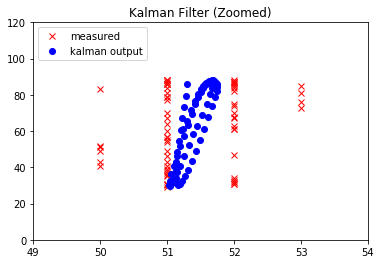

In [13]:
#(filtered_state_means, filtered_state_covariances) = kf.filter(MarkedMeasure)
(smoothed_state_means, smoothed_state_covariances) = kf.em(MarkedMeasure).smooth(MarkedMeasure)
# comment out one of these above ^^^

plt.plot(MarkedMeasure[:,0],MarkedMeasure[:,1],'xr',label='measured')
plt.axis([49,54,0,120]) # 48,55 -- 40,60
plt.hold(True)

#plt.plot(filtered_state_means[:,0],filtered_state_means[:,1],'ob',label='kalman output')
plt.plot(smoothed_state_means[:,0],smoothed_state_means[:,1],'ob',label='kalman output')
# comment out the corresponding filtering method to the above comment out in this cell

plt.legend(loc=2)
plt.title("Kalman Filter (Zoomed)")

plt.savefig("Kalman Filter (Zoomed).png")

plt.show()

In [14]:
#kalmanX = filtered_state_means[:,0]
#kalmanY = filtered_state_means[:,1] 

# comment out above or below based on previous comments

kalmanX = smoothed_state_means[:,0]
kalmanY = smoothed_state_means[:,1]


In [16]:
# for plotting kalman output w/o the other center point on its own unique frame
for i in range(80):
    frame = "Frames/frame%d.png" % i
    idx = frame.index('/')
    frame_path = frame[:idx] + "/Kalman" + frame[idx:]
    

    img = Image.open(frame)
    pixelMap = img.load()
    pixelMap[kalmanX[i]+1, kalmanY[i]] = (0, 254, 254, 255)
    pixelMap[kalmanX[i]-1, kalmanY[i]] = (0, 254, 254, 255)
    pixelMap[kalmanX[i]+1, kalmanY[i]+1] = (0, 254, 254, 255)
    pixelMap[kalmanX[i]-1, kalmanY[i]-1] = (0, 254, 254, 255)
    pixelMap[kalmanX[i], kalmanY[i]] = (0, 254, 254, 255)
    pixelMap[kalmanX[i], kalmanY[i]+1] = (0, 254, 254, 255)
    pixelMap[kalmanX[i], kalmanY[i]-1] = (0, 254, 254, 255)
    pixelMap[kalmanX[i]-1, kalmanY[i]+1] = (0, 254, 254, 255)
    pixelMap[kalmanX[i]+1, kalmanY[i]-1] = (0, 254, 254, 255)
    py.imsave(frame_path, img)
    

In [31]:
# for plotting on the same frame as measured center point -- note: overwrites Center

for i in range(80):
    frame = "Frames/Center/frame%d_center.png" % i

    img = Image.open(frame)
    pixelMap = img.load()
    pixelMap[kalmanX[i]+1, kalmanY[i]] = (0, 254, 254, 255)
    pixelMap[kalmanX[i]-1, kalmanY[i]] = (0, 254, 254, 255)
    pixelMap[kalmanX[i]+1, kalmanY[i]+1] = (0, 254, 254, 255)
    pixelMap[kalmanX[i]-1, kalmanY[i]-1] = (0, 254, 254, 255)
    pixelMap[kalmanX[i], kalmanY[i]] = (0, 254, 254, 255)
    pixelMap[kalmanX[i], kalmanY[i]+1] = (0, 254, 254, 255)
    pixelMap[kalmanX[i], kalmanY[i]-1] = (0, 254, 254, 255)
    pixelMap[kalmanX[i]-1, kalmanY[i]+1] = (0, 254, 254, 255)
    pixelMap[kalmanX[i]+1, kalmanY[i]-1] = (0, 254, 254, 255)
    
    py.imsave(frame, img)